In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx
import scipy.interpolate
import time

In [410]:
# directory on personal computer
ruta = 'C:/Users/User/Desktop/Pan American Energy/reference scripts/initial'
os.chdir(ruta)

ruta_logs = ruta + "/Datos VH_III"
ruta_archivo = ruta_logs +"/Datos VH_III.xlsx"

las_files = glob.glob(os.path.join(ruta_logs, '*.las'))
log_files = glob.glob(os.path.join(ruta_logs, '*.log'))


# Create a directed graph
G = nx.DiGraph()

# get data from excel
well_data = pd.read_excel(ruta_archivo)

def las_to_node(G, filename, col_name):
    node_name = os.path.splitext(os.path.basename(filename))[0]
    las = lasio.read(filename)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()
    new_las = pd.DataFrame(columns=["DEPTH",'RES_DEEP'])
    new_las["DEPTH"] = las_df["DEPTH"]
    new_las["RES_DEEP"] = las_df[col_name]

    coord_data = well_data[well_data["Nombre"]==node_name]
    x_coord = coord_data.iloc[0, 5]
    y_coord = coord_data.iloc[0, 6]

    G.add_node(node_name, data=new_las, pos=(x_coord, y_coord))

    # Add tops
    tops_data = pd.read_excel(ruta_archivo, sheet_name=node_name)
    tops_data = tops_data.drop(index=0)

    a = tops_data[["Capa", "Top"]].copy()
    a.rename(columns={"Top": "Ref"}, inplace=True)

    

    b=tops_data[["Capa", "Base"]].copy()
    b.rename(columns={"Base": "Ref"}, inplace=True)
    resultado = pd.concat([a, b], ignore_index=True)

    tops_vals = resultado.sort_values(by='Ref', ascending=True).reset_index().dropna()

    # print(f"Resultados {node_name}")
    # print(resultado.head(5))
    # print()



    G.nodes[node_name]["known_tops"]=tops_vals.copy()

def log_to_node(G, filename, col_name):
    log_data = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Identify header and determine the indices of the columns of interest
    header = lines[0].strip().split()
    depth_idx = header.index("DEPTH")
    col_idx = header.index(col_name)

    new_log = pd.DataFrame(columns=["DEPTH",'RES_DEEP'])

    new_log["DEPTH"] = lines[depth_idx]
    new_log["RES_DEEP"] = lines[col_idx]

    print(lines[2])


las_to_node(G, las_files[0], "HT90")
las_to_node(G, las_files[1], "HT90")
las_to_node(G, las_files[2], "HDRS")

#log_to_node(G, log_files[0], "M2R9")




Un grafo ciclico con 3 nodos, esto podria cambiar en el futuro

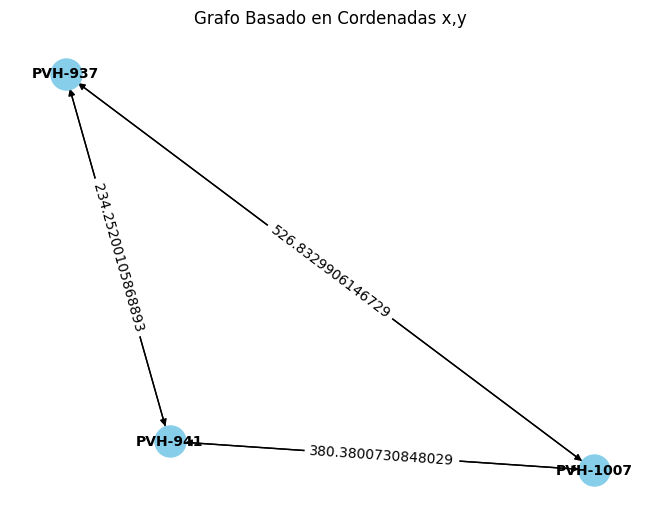

In [411]:
#%%
# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def euclidian_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

threshold_distance = 2000  # Define a distance threshold

for node1, data1 in G.nodes(data=True):
    for node2, data2 in G.nodes(data=True):
        if node1 != node2:
            pos1 = data1['pos']
            pos2 = data2['pos']
            distance = euclidian_distance(pos1[0], pos1[1], pos2[0], pos2[1])
            if distance <= threshold_distance:
                G.add_edge(node1, node2, weight=distance)

# Visualize the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Grafo Basado en Cordenadas x,y")
plt.show()

In [412]:
print(G.nodes["PVH-937"]["data"].head(100))

      DEPTH  RES_DEEP
0   874.575    2.6455
1   874.700    2.5251
2   874.825    2.3703
3   874.950    2.2122
4   875.075    2.1082
..      ...       ...
95  886.450    2.3704
96  886.575    2.4442
97  886.700    2.5007
98  886.825    2.5909
99  886.950    2.7594

[100 rows x 2 columns]


Esto es el algoritmo principal. *dtw_calc* hace la computacion principal. *calc_tops* actualiza los datos de tops del siguiente nodo. *profiles_comparison* crea un grafico del dtw path

In [413]:

# helper methods
def normalize_array(arr):
    reshaped_arr = arr.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_arr = scaler.fit_transform(reshaped_arr)
    return normalized_arr

def custom_distance(p1, p2):
    return np.abs(p1 - p2) **(1/ 4.3)



# node 1 is the curernt node
# node 2 is the node you attempt to move to
# function gets a dataframe with the predicted depths, assigns to "tops" label in node
def calc_tops(G, node1, node2):

    # create a new dataframe that takes the values of node2 where the "capa" value is the same as in node1
    
    
    correla, df1, df2 = dtw_calc(G, node1, node2)
    
    df_result = pd.DataFrame(columns=["Capa",'Ref'])

    # create a list of j values for unique i values
    j_values_dict = {}

    for i, j in correla:
        
        if i not in j_values_dict:
            j_values_dict[i] = []
        j_values_dict[i].append(j)

    rows_to_add = []
    # obtaining a 1 to 1 relationship between i and j by averaging 
    for i, j_values in j_values_dict.items():
        i_depth = df1["DEPTH"].iloc[i]
        j_depths = [df2["DEPTH"].iloc[j] for j in j_values]
        # averaging j values
        j_depth = np.mean(j_depths) # averaging, may want to try a different method later
        #print(f'i = {i_depth}, j = {j_depths}') #print the j values for each corresponding i value
        rows_to_add.append({'Ref': j_depth})

    capas = G.nodes[node1]["known_tops"]["Capa"]
    
    df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)
    df_result["Capa"] = capas

    # assign new top values to the node
    G.nodes[node2]["tops"]=df_result
    #print(G.nodes[node2]["tops"])


def dtw_calc(G, node1, node2):
    tolerance = 0.1 #original 0.05, was too small
    df1 = G.nodes[node1]["data"].copy() # RES_DEEP data for node1
    tops1 = G.nodes[node1]["known_tops"].copy() # Tops data for node1

    #filter the tops data to only include the tops present in both datasets
    # capas1_names = G.nodes["PVH-937"]["known_tops"]["Capa"]  # List of names
    # capas2 = G.nodes["PVH-941"]["known_tops"].copy()
    # tops1 = capas2[capas2["Capa"].isin(capas1_names)]


    num_matches = tops1.shape[0] # This is how many points of interest are in the dataset, this should be the size of the output too

    df2 = G.nodes[node2]["data"].copy() # RES_DEEP data for node2



    # mark rows within the tolerance range of any top
    
    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']
        matches = tops1['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)
        
        if matches.any():
            df1.at[index_df1, 'Present'] = 1
            matched_index = matches.idxmax()
            tops1 = tops1.drop(index=matched_index)
            
            # If tops1 is empty, break the loop
            if tops1.empty:
                break
            

    G.nodes[node1]["is_top"] = df1[df1['Present'] == 1] # store the filtered rows near the caps into the graph
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50
    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()


    # normalize res deep in df1 and df2
    w1 = np.array(df1['RES_DEEP'].dropna())
    w2 = np.array(df2['RES_DEEP'].dropna())
    # might need to use normalized values later, not rn tho
    w1_normalized = normalize_array(w1)
    w2_normalized = normalize_array(w2)


    ref = df1[df1["Present"] == 1]
    distance, path = fastdtw(w1_normalized, w2_normalized, dist=custom_distance)
    # distance, path = fastdtw(w1_normalized, w2_normalized, dist=custom_distance) Might need to normalize later
    correla = [tupla for tupla in path if tupla[0] in ref.index]

    #mark tops in df2, this block of code is not necessary
    # correla2 = [tupla[1] for tupla in correla]
    # df2["is_top"] = 0
    # for elemento in correla2:
    #     if elemento in df2.index:
    #         df2.loc[elemento, "is_top"] = 1
    # G.nodes[node2]["is_top"] = df2[df2["is_top"] == 1]
    # G.nodes[node2]["Procesados"] = df2
    return correla, df1, df2


def profiles_comparison(G, node1, node2, r=None):
    correla, df1, df2 = dtw_calc(G, node1, node2)

    offset = 50
    plt.figure(figsize=(10, 6))

    # Plot df1
    plt.plot(df1["DEPTH"], df1["RES_DEEP"], label=node1, color='blue')

    # Plot df2 with offset
    plt.plot(df2["DEPTH"], df2["RES_DEEP"] + offset, label=node2, color='orange')

    for i, j in correla:
        # Plot the DTW path
        plt.plot([df1["DEPTH"].iloc[i], df2["DEPTH"].iloc[j]], [df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], color='red', linestyle='-')

    plt.title(f"Reference Node: {node1}, Prediction Node: {node2}")
    plt.xlabel('Depth (m)')
    if r:
        plt.xlim(r[0], r[1])
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()


Aqui se corre el algoritmo, calculando los topes de 1499 usando los datos de 1318

C:\Users\User\AppData\Local\Temp\ipykernel_21552\3065209442.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


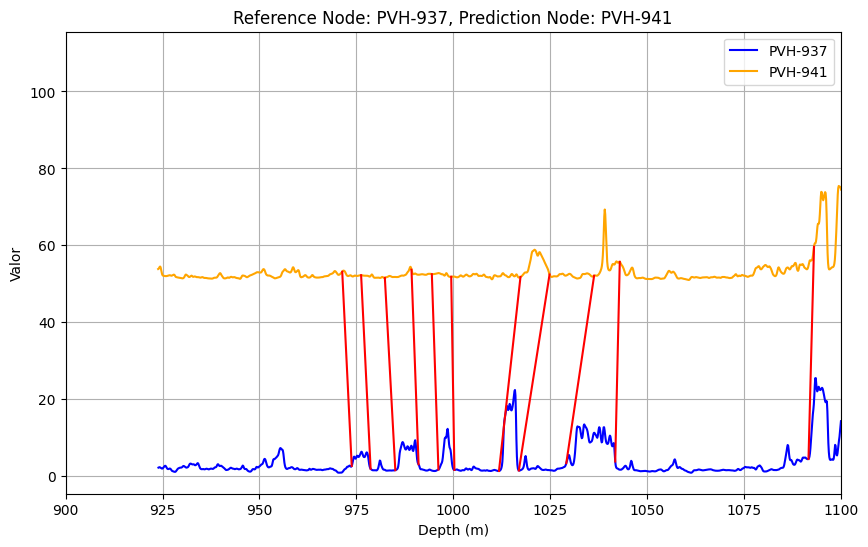

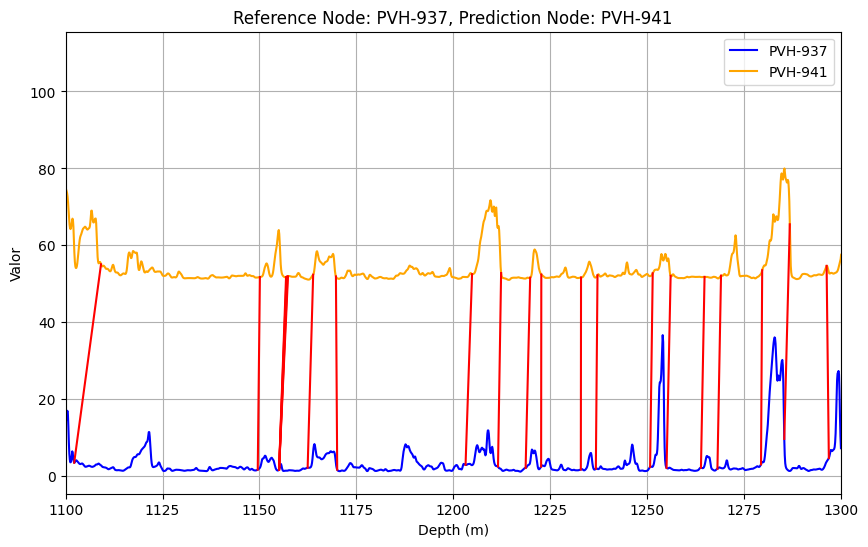

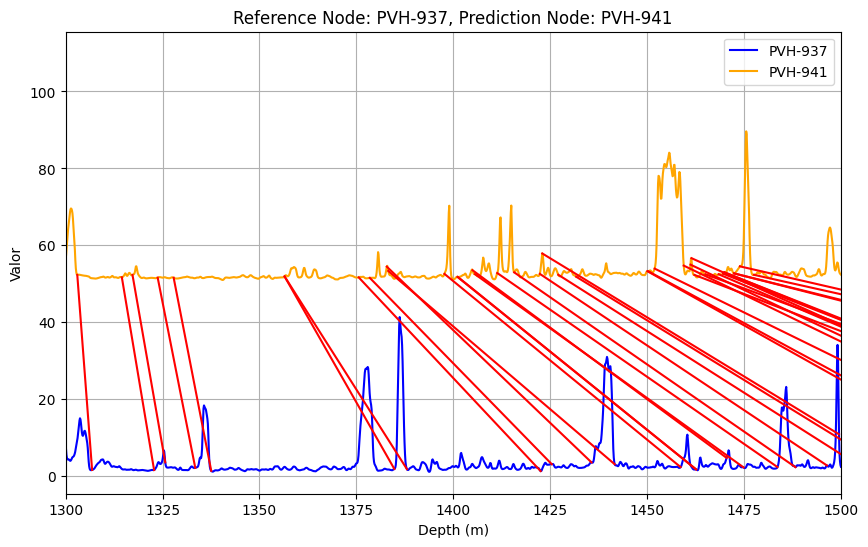

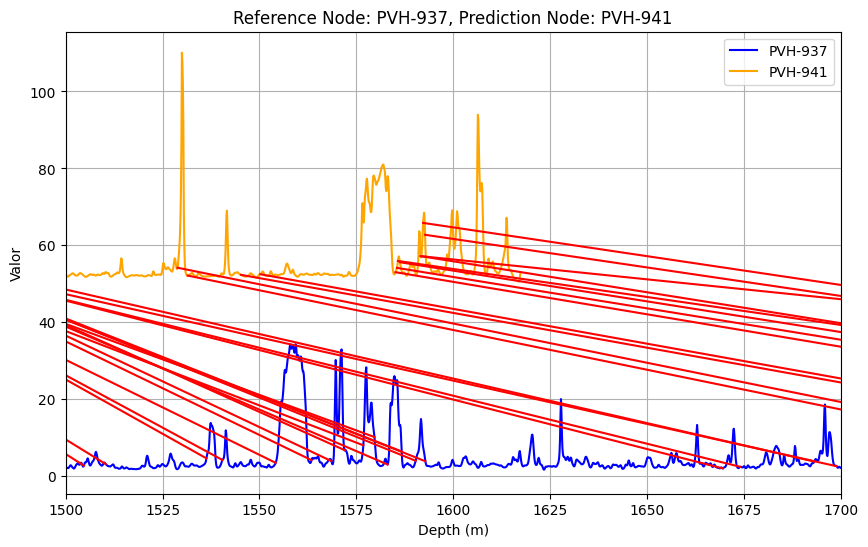

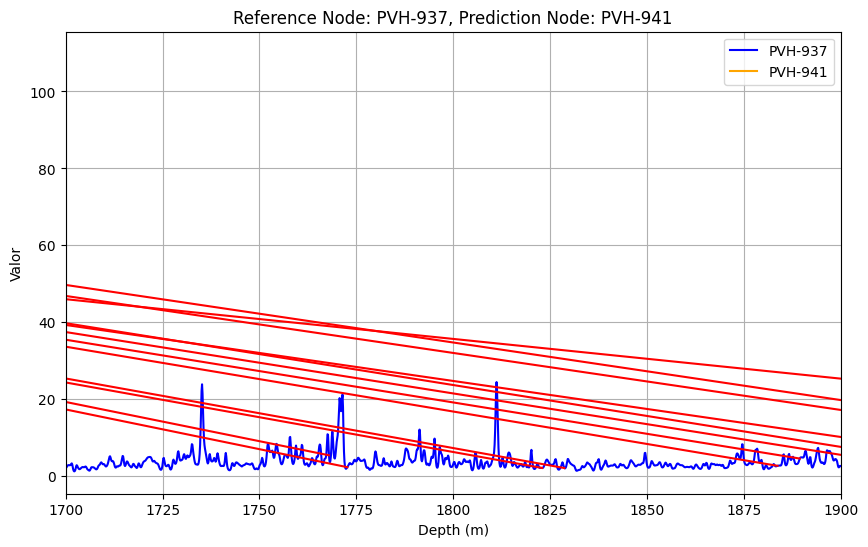

In [414]:


calc_tops(G, "PVH-937", "PVH-941")

def generate_ranges(start, end, step):
    return [(i, i + step) for i in range(start, end, step)]

ranges = generate_ranges(900, 1800, 200)

for r in ranges:
    profiles_comparison(G, "PVH-937", "PVH-941", list(r))


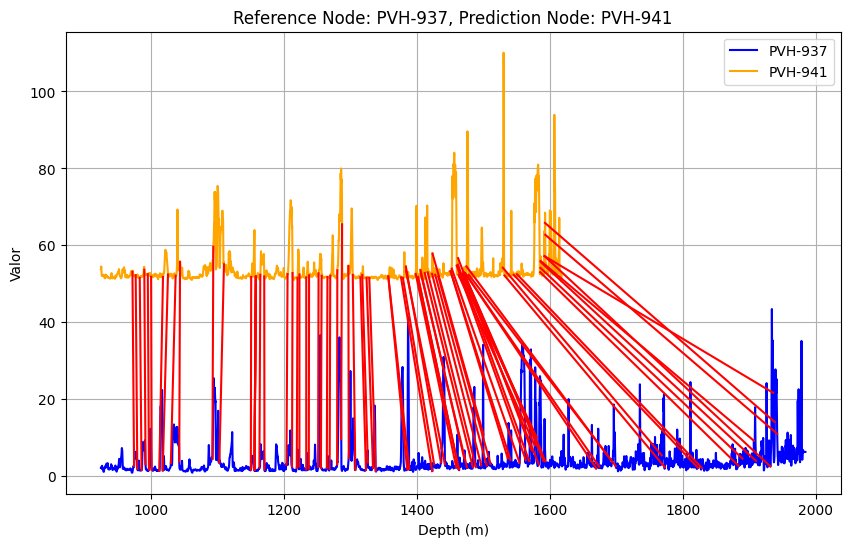

In [415]:
profiles_comparison(G, "PVH-937", "PVH-941")

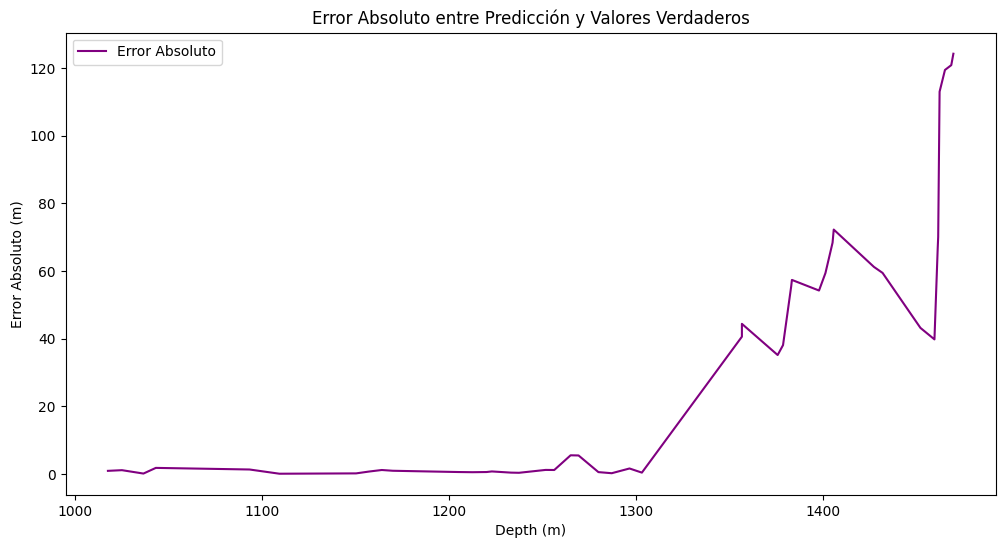

In [416]:
#print(G.nodes["PVH-941"]["tops"].head(20))
#print(G.nodes["PVH-941"]["known_tops"])

known_937 = G.nodes["PVH-937"]["known_tops"].copy()
known_941 = G.nodes["PVH-941"]["known_tops"].copy()
calc_941 = G.nodes["PVH-941"]["tops"].copy()

#print(known_941.head(20))
names_941 = known_941["Capa"]
error_df = calc_941[calc_941["Capa"].isin(names_941)].reset_index()
error_df["real ref"] = known_941["Ref"]

error_df["abs error"] = np.abs(error_df['Ref'] - error_df['real ref'])


plt.figure(figsize=(12, 6))
plt.plot(error_df['Ref'], error_df['abs error'], label='Error Absoluto', color='purple')
plt.xlabel('Depth (m)')
plt.ylabel('Error Absoluto (m)')
plt.title('Error Absoluto entre Predicción y Valores Verdaderos')
plt.legend()
plt.show()


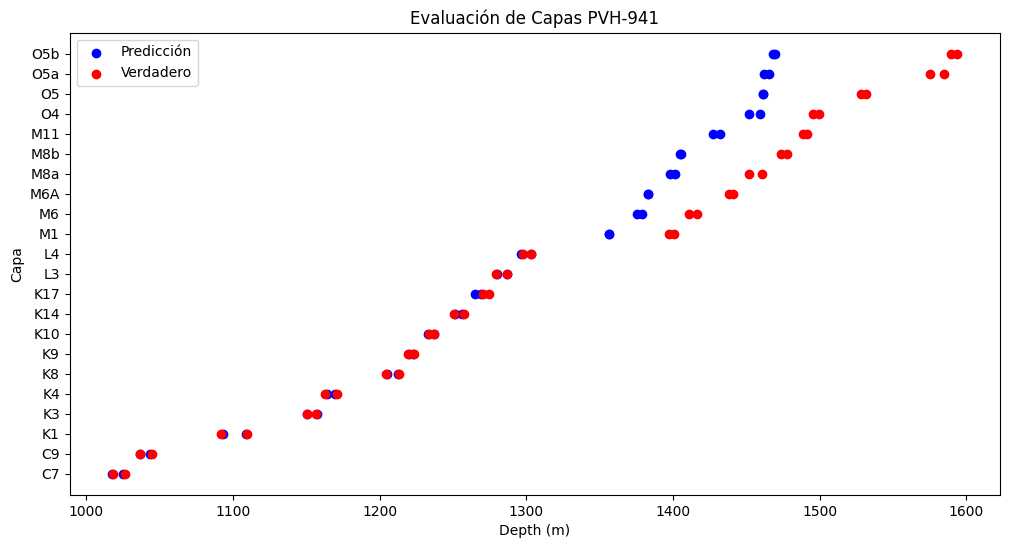

In [417]:

# Resultados
plt.figure(figsize=(12, 6))
plt.scatter(error_df['Ref'], error_df['Capa'], color='blue', label='Predicción')
plt.scatter(error_df['real ref'], error_df['Capa'], color='red', label='Verdadero')

plt.xlabel('Depth (m)')
plt.ylabel('Capa')
plt.title('Evaluación de Capas PVH-941')
plt.legend()
plt.show()

Se nota que los errores comienzan despues de 1300 m de profundidad, ahora voy a cortar la ventana para ver si puede funcionar en esas profundidades

In [418]:


# filtered_df1 = G.nodes["PVH-937"]["data"].copy(deep=False)
# filtered_df1 = filtered_df1[(filtered_df1["DEPTH"]>=1550) & (filtered_df1["DEPTH"]<=1600)]
# G.nodes["PVH-937"]["data"] = filtered_df1

# filtered_df2 = G.nodes["PVH-941"]["data"].copy(deep=False)
# filtered_df2 = filtered_df2[filtered_df2["DEPTH"]>=1525]
# G.nodes["PVH-941"]["data"] = filtered_df2

# filtered_t1 = G.nodes["PVH-937"]["known_tops"].copy(deep=False)
# filtered_t1 = filtered_t1[(filtered_t1["Ref"]>=1550) & (filtered_t1["Ref"]<=1600)]
# G.nodes["PVH-937"]["known_tops"] = filtered_t1

# #print(filtered_df1)
# profiles_comparison(G, "PVH-937", "PVH-941", [1500, 1700])



